In [1]:
# 预处理
# 1.读取NIFTI格式的图片文件和mask
# 2.显示一层图片（包含mask）
# 3.动态显示整个扫描（显示一个文件的多层图像信息）
# 4.构造归一化，标准化函数
# 5.预处理所以文件，保存为np文件，存在磁盘
# 6.检查一下存储的np文件是否合格

In [2]:
import nibabel as nib

In [3]:
# 挑一个文件测试
test_file = './data/imagesTr/la_018.nii.gz'

# 对应的标注文件
test_mask = './data/labelsTr/la_018.nii.gz'

In [4]:
# 读取文件
img = nib.load(test_file)
mask = nib.load(test_mask)

In [5]:
# 获取数据
img_data = img.get_fdata()
mask_data = mask.get_fdata()

In [6]:
# 查看大小
img_data.shape, mask_data.shape  # 三种切片对应三种位置，固定其中某两个作为图片，剩下一维作为层

((320, 320, 122), (320, 320, 122))

In [7]:
# 显示图片
import matplotlib.pyplot as plt
import numpy as np

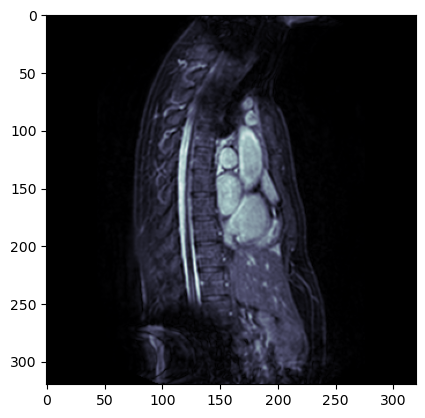

In [8]:
plt.imshow(np.rot90(img_data[:, :, 80]), cmap='bone')  # 前面两位看作图片

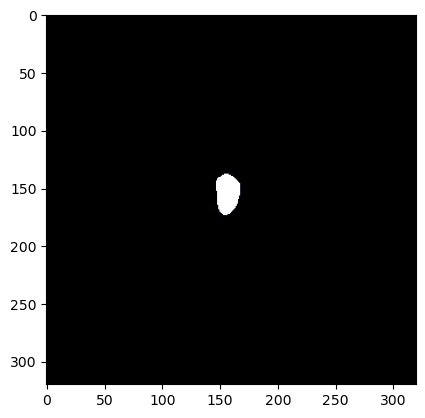

In [9]:
plt.imshow(np.rot90(mask_data[:, :, 80]), cmap='bone')  # 显示掩码

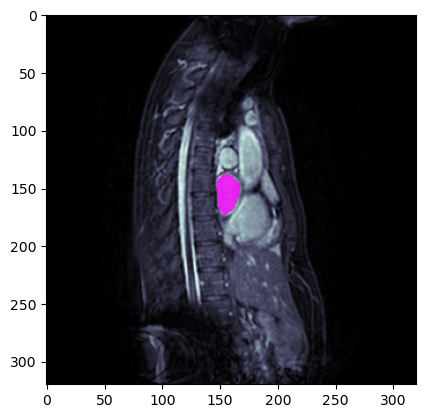

In [10]:
# 将mask和图片绘制在一起
img_display = np.rot90(img_data[:, :, 80])
mask_display = np.rot90(mask_data[:, :, 80])

# 将mask_display像素值为0的区域遮挡起来
mask = np.ma.masked_where(mask_display == 0, mask_display)
plt.imshow(img_display, cmap='bone')
plt.imshow(mask, alpha=0.8, cmap='spring')

In [11]:
# 将122 层画面合成为动画
from celluloid import Camera
from IPython.display import HTML
import tqdm  # 进度条显示工具

In [12]:
img_data.shape

(320, 320, 122)

100%|██████████| 122/122 [00:00<00:00, 172.52it/s]


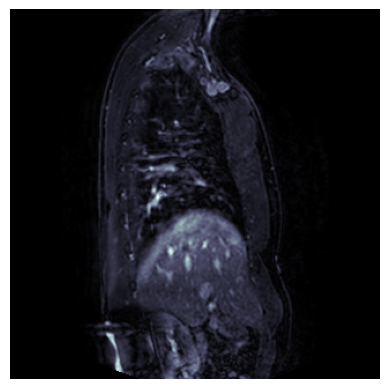

In [13]:
# 遍历每一层图像和mask
fig = plt.figure()
camera = Camera(fig)
for i in tqdm.tqdm(range(img_data.shape[-1])):
    # 将mask和图片绘制在一起
    img_display = np.rot90(img_data[:, :, i])
    mask_display = np.rot90(mask_data[:, :, i])


    # 将mask_display像素值为0的区域遮挡起来
    mask = np.ma.masked_where(mask_display == 0, mask_display)
    plt.imshow(img_display, cmap='bone')
    plt.imshow(mask, alpha=0.8, cmap='spring')

    plt.axis('off')

    camera.snap()


In [14]:
animation = camera.animate()  # 动起来

In [15]:
# 显示动画
HTML(animation.to_html5_video())  # conda install -c conda-forge ffmpeg

In [16]:
# 下一步处理整个文件
# 为什么要标准化？ 加速模型收敛
img_data.max(),img_data.min()

(2095.0, 0.0)

### 标准化
$$ x' = \frac{x - mean(x)}{\sigma} $$

### 归一化
$$ x' = \frac{x - min(x)}{max(x) - min(x)}$$

In [17]:
# 标准化
def standardize(data):
    # 计算均值
    mean = data.mean()
    # 计算标准差
    std = np.std(data)

    # 计算结果
    standardized = (data - mean) / std

    return standardized

# 归一化
def normalize(data):
    max_val = data.max()
    min_val = data.min()

    normalized = (data - min_val)/(max_val - min_val)

    return normalized

In [18]:
# 测试处理第80层
test_data = img_data[:,:,80]

In [19]:
std = standardize(test_data)

In [20]:
std.max(),std.min()

(5.628479883541003, -0.6118425303834774)

In [21]:
nor = normalize(std)

In [22]:
nor.max(),nor.min()

(1.0, 0.0)

In [23]:
# 处理所有文件
import glob
import os

In [24]:
# 获取文件列表 (图片和标注)
train_file_list = glob.glob('./data/imagesTr/la*')
train_label_list = glob.glob('./data/labelsTr/la*')

In [71]:
# 遍历每个文件，每个文件包含多层图像，保存为np文件
for index,file in enumerate(train_file_list):
    # 读取文件和label
    # 对原始图片适当裁剪边缘
    # 输出为256*256的图片
    # 标准化，归一化
    # 存入文件夹
    img = nib.load(file)
    mask = nib.load(train_label_list[index])

    img_data = img.get_fdata()
    mask_data = img.get_fdata()

    # 裁剪边缘
    img_data_crop = img_data[32:-32,32:-32]
    mask_data_crop = mask_data[32:-32,32:-32]

    # 标准化归一化
    std = standardize(img_data_crop)
    nor = normalize(std)

    print(nor.shape)

    # 分为训练集和测试集
    if index <17:
        # 训练集
        savedir = 'processed/train/'
    else:
        # 训练集
        savedir = 'processed/test/'

    # 遍历所有层，分层存入文件夹，存储路径格式：'processed/train/0/img_0.npy'，'processed/train/0/label_0.npy'，
    #train ，test表示训练集和测试集
    #train/0 表示文件序号
    # img_0.npy，label_0.npy 分别表示该文件的第一层图像及其对应的标注（最终到122）

    # 获取层数
    layer_num = nor.shape[-1]
    for i in range(layer_num):
        # 获取第i层的图像及标注
        layer = nor[:,:,i]
        mask = mask_data_crop[:,:,i]

        # 创建文件夹
        img_dir = savedir + str(index)
        # 如果没有该文件夹就创建
        if not os.path.exists(img_dir):
            os.makedirs(img_dir)

        # 保存numpy文件
        np.save(img_dir + '/img_' + str(i),layer)
        np.save(img_dir + '/img_' + str(i),mask)


    # break

(256, 256, 130)


In [25]:
# 检查数据是否合格
# 解决排序混乱问题
from natsort import natsorted # pip install natsort
img_test =natsorted( glob.glob('processed/train/15/img*'))
label_test = natsorted( glob.glob('processed/train/15/label*') )

In [26]:
len(img_test),len(label_test)

(110, 110)

In [27]:
# 遍历每一层图像和mask
fig = plt.figure()
camera = Camera(fig)
for index,img_file in enumerate(img_test):
    # 加载图片
    img_data = nib.load(img_file)
    mask_data = nib.load(label_test[index])
    # 将mask和图片绘制在一起
    img_display = np.rot90(img_data)
    mask_display = np.rot90(mask_data)


    # 将mask_display像素值为0的区域遮挡起来
    mask = np.ma.masked_where(mask_display == 0, mask_display)
    plt.imshow(img_display, cmap='bone')
    plt.imshow(mask, alpha=0.8, cmap='spring')

    plt.axis('off')

    camera.snap()
animation = camera.animate()

ImageFileError: Cannot work out file type of "processed/train/15/img_0.npy"

<Figure size 640x480 with 0 Axes>

In [28]:
# 显示动画
HTML(animation.to_html5_video())